In [1]:
# Load modules
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(rc={'figure.figsize':(8,8)})
import IPython
import random as rd
import copy
import time
import math
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Import dataset and reorder data columns to better represent maturation of individual organs
metData = pd.read_excel("../microtomMetaboliteAccumulation.xlsx")
metData = metData.set_index("Index")
metData = metData[["Q1 (Da)", "Q3 (Da)", "Rt (min)", "Molecular Weight (Da)", "Ionization model", "KEGG ID", "Compound name", "Class",
"R30", "R45", "R85", "S30", "S45", "S85", "L30", "L45", "L85", "F30", "F45", "10DPA", "20DPA", "IMG", "MG", "Br", "Br3", "Br7", "Br10", "Br15"]]

# Subset metabolite data to include only flavonoids, hydroxycinnamoyl & derivatives, and benzoic acids and derivatives
subsetMetData = metData[metData.Class.isin(["Flavonoids", "Hydroxycinnamoyl and derivatives", "Benzoic acid and derivatives"])]
justData = subsetMetData.iloc[:, subsetMetData.shape[1]-20:subsetMetData.shape[1]]

# Perform sample-wise z-score normalization of data
justDataTF = stats.zscore(justData, axis=1)
justDataTF = pd.DataFrame(justDataTF, columns=justData.columns, index=subsetMetData.index)

# Add information about metabolites back to dataframe 
subsetMetDataTF = subsetMetData.iloc[:, 0:subsetMetData.shape[1]-20]
subsetMetDataTF = pd.concat([subsetMetDataTF, justDataTF], axis=1)

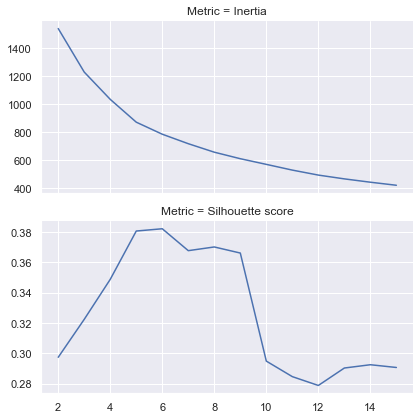

In [3]:
# Apply k-means clustering
# First determine optimal number of clusters using elbow method
clusterData = copy.deepcopy(justDataTF)
modelInertias = []
modelSilhouettes = []
numClusters = range(2, 16)


for k in numClusters:
    model = KMeans(init="k-means++", n_clusters=k, n_init=500, max_iter=5000)
    model = model.fit(clusterData)
    modelInertias.append(model.inertia_)
    modelSilhouettes.append(silhouette_score(clusterData, model.labels_))

modelEvalData = pd.DataFrame({"Number of clusters":numClusters, "Inertia":modelInertias, "Silhouette score":modelSilhouettes})

modelEvalData = pd.melt(modelEvalData, id_vars="Number of clusters", var_name="Metric", value_name="Value")
modelEvalPlot = sns.FacetGrid(modelEvalData, row="Metric", sharey=False, height=3, aspect=2)
modelEvalPlot.map_dataframe(sns.lineplot, x="Number of clusters", y="Value")

<AxesSubplot:ylabel='Index'>

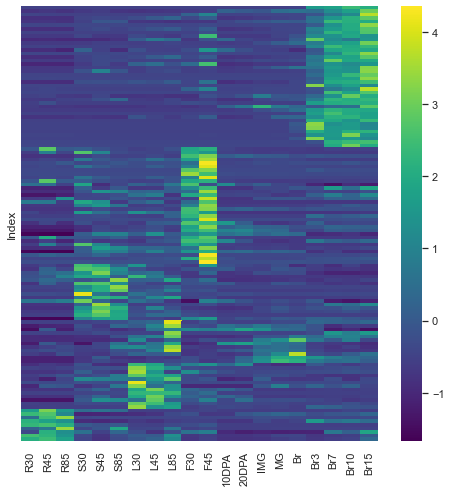

In [4]:
# 6 clusters is optimal number for dataset - run k-means clustering with 6 clusters
model = KMeans(init="k-means++", n_clusters=6, n_init=500, max_iter=5000)
model = model.fit(clusterData)
clusterData.insert(0, column="Cluster", value=model.labels_)

# Draw heatmap with data sorted into clusters as determined by k-means clustering
plotClusterData = clusterData.sort_values(by="Cluster")
plotClusterData = plotClusterData.drop("Cluster", axis=1)
sns.heatmap(data=plotClusterData, yticklabels=False, cmap="viridis")

In [5]:
# Export the data as a .csv file so it can be used in further correlation analysis
subsetMetDataTF.insert(0, column="Cluster", value=model.labels_)
subsetMetDataTF.to_csv(path_or_buf="subsetMetDataTF.csv", index=True)